In [ ]:
#Import necessary Packages

import zipfile
import io
import tarfile
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import copy

# 1.Load Data

In [ ]:
# Replace 'filename.zip' with the actual name of your uploaded zip file
ZIP_FILE = '/content/drive/MyDrive/Test_object_classification/caltech-101.zip'
TAR_FILE = '/content/caltech-101/101_ObjectCategories.tar.gz'
#unzip the data file
with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
  zip_ref.extractall('/content/')
with tarfile.open(TAR_FILE, 'r:gz') as tar:
  tar.extractall('/content/caltech-101/')  # Extract to the specified directory


# 2.Convert the data into dataframe

In [ ]:
#Path of the data
Dir_DATA =  '/content/caltech-101/101_ObjectCategories'

file_paths = [] #image path
labels = []     #name of the classes of the dataset
for class_name in os.listdir(Dir_DATA):
    class_path = os.path.join(Dir_DATA, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        file_paths.append(img_path)
        labels.append(class_name)
# Create a DataFrame
df = pd.DataFrame({'Filepath': file_paths, 'Label': labels})

In [ ]:
df

,Filepath,Label
0,/content/caltech-101/101_ObjectCategories/pige...,pigeon
1,/content/caltech-101/101_ObjectCategories/pige...,pigeon
2,/content/caltech-101/101_ObjectCategories/pige...,pigeon
3,/content/caltech-101/101_ObjectCategories/pige...,pigeon
4,/content/caltech-101/101_ObjectCategories/pige...,pigeon
...,...,...
9140,/content/caltech-101/101_ObjectCategories/BACK...,BACKGROUND_Google
9141,/content/caltech-101/101_ObjectCategories/BACK...,BACKGROUND_Google
9142,/content/caltech-101/101_ObjectCategories/BACK...,BACKGROUND_Google
9143,/content/caltech-101/101_ObjectCategories/BACK...,BACKGROUND_Google


# 3.Data Exploring

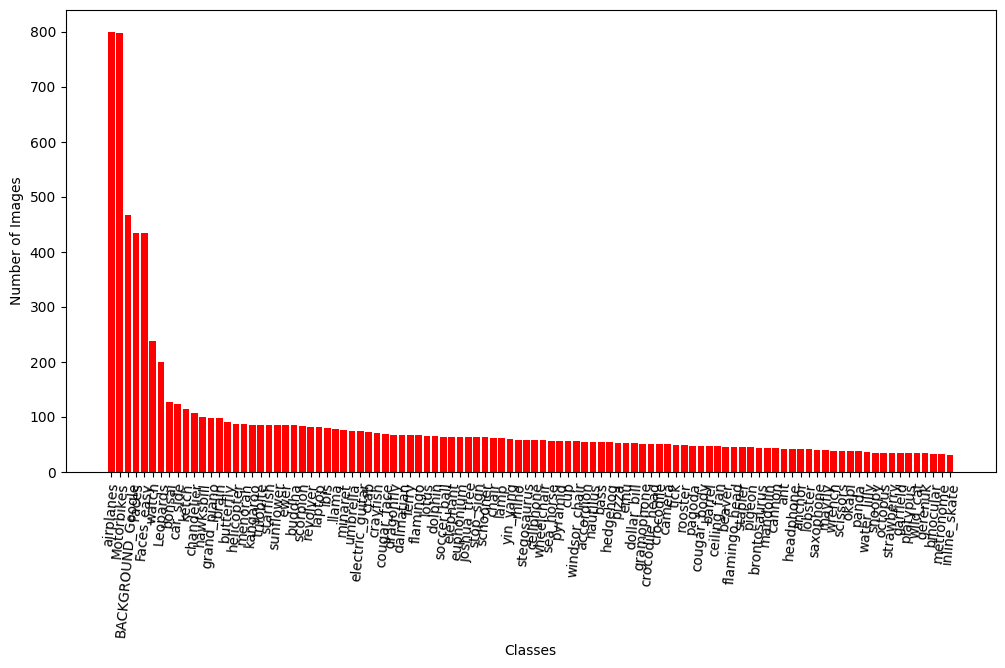

In [ ]:
#Count the number of image per label ot the class
class_counts = df['Label'].value_counts().sort_values(ascending=False)
# Create a bar plot
plt.figure(figsize=(12, 6))
plt.xticks(rotation=85)
plt.bar(class_counts.keys(),class_counts.values,color='red')  # Use class_counts.index for class names
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

# 4.Select the top 5 classes from Caltech-101 dataset

In [ ]:
#Extract the label name that has the highest number of images
#filter dataframe and Extract top 5 class counts
class_counts = df['Label'].value_counts().head(5)
# Filter the DataFrame based on top 5 classes
filtered_df = df[df['Label'].isin(class_counts.index)]
top_classes = [i for i in  filtered_df ['Label'].unique()]

In [ ]:
filtered_df

,Filepath,Label
712,/content/caltech-101/101_ObjectCategories/Face...,Faces_easy
713,/content/caltech-101/101_ObjectCategories/Face...,Faces_easy
714,/content/caltech-101/101_ObjectCategories/Face...,Faces_easy
715,/content/caltech-101/101_ObjectCategories/Face...,Faces_easy
716,/content/caltech-101/101_ObjectCategories/Face...,Faces_easy
...,...,...
9140,/content/caltech-101/101_ObjectCategories/BACK...,BACKGROUND_Google
9141,/content/caltech-101/101_ObjectCategories/BACK...,BACKGROUND_Google
9142,/content/caltech-101/101_ObjectCategories/BACK...,BACKGROUND_Google
9143,/content/caltech-101/101_ObjectCategories/BACK...,BACKGROUND_Google


In [ ]:
#display the list of top classes names
top_classes

['Faces_easy', 'Motorbikes', 'Faces', 'airplanes', 'BACKGROUND_Google']

# 5. Split the data into train , valid and test

In [ ]:
# Split the filtered dataframe into train, validation, and test sets
train_data, temp_data = train_test_split(filtered_df, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)
# Resetting the indices
train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

#6. Data Preprocessing

**The data preprocessing involves resizing the input image to match the input size layer of the pre-trained model and converting it into an array.**

In [ ]:

def data_preprocessing(dataframe):
  dataset = []
  # Define transformations
  transform = transforms.Compose([
      transforms.Resize((224, 224)),# Resize the image to be match with input size of the AlexNet
      transforms.ToTensor(),#convet an image to an array
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#Normalizing images
      ])
  for idx in range(len(dataframe)):
    img_path = dataframe.loc[idx,'Filepath']
    #read the image
    image = Image.open(img_path).convert('RGB')
    label = top_classes.index(dataframe.loc[idx, 'Label'])
    # Apply transformation
    image = transform(image)
    #add the pre-processed image in the list called dataset
    dataset.append((image, label))
  return dataset
#preprocessed the split data
train_dataset = data_preprocessing(train_data)
valid_dataset = data_preprocessing(valid_data)
test_dataset  = data_preprocessing(test_data)

**DataLoader loads data in batches during the training, validation, and testing processes. This speeds up training by providing batch sample data.**

In [ ]:
#loading and  processing during Training,validation and testing process
#define number of the bach size
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)#load the train data with randomly samples
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Check the number of images and class balances in the  train, validation and test set

In [ ]:
print('Number of labels of train set',train_data['Label'].count())
print('Number of images of train set',train_data['Filepath'].count())
print('Number of labels of valid set',valid_data['Label'].count())
print('Number of images of valid set',valid_data['Filepath'].count())
print('Number of labels of test set',test_data['Label'].count())
print('Number of images of test set',test_data['Filepath'].count())

Number of labels of train set 2348
Number of images of train set 2348
Number of labels of valid set 294
Number of images of valid set 294
Number of labels of test set 294
Number of images of test set 294


# Some examples of images from dataset

In [ ]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()





BACKGROUND_Google
(528, 705, 3)


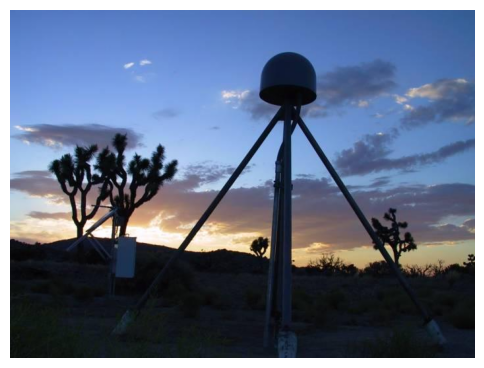

In [ ]:
# Example image
x = Image.open(train_data['Filepath'][11])
print(train_data['Label'][11])
print(np.array(x).shape)
imshow(x)

Motorbikes
(136, 267, 3)


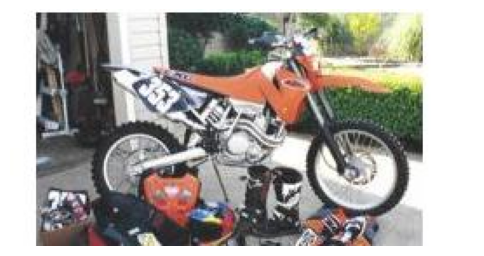

In [ ]:
# Example image
x = Image.open(train_data['Filepath'][0])
print(train_data['Label'][0])
print(np.array(x).shape)
imshow(x)

# Training the model

In [ ]:
# Set a random seed for NumPy
np.random.seed(42)#fix the choosen weights
#define number of epochs
NUM_EPOCHS = 5

In [ ]:
def train_model(model,train_loader, valid_loader,  criterion, optimizer,num_epochs,patience=5):
    val_acc_history = []
    train_acc_history = []
    no_improvement_count = 0
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        train_corrects = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)#label predict
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)
        train_acc = train_corrects.double() / len(train_loader.dataset) * 100
        train_acc_history.append(train_acc.item())
        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            valid_corrects = 0
            for images, labels in valid_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                valid_corrects += torch.sum(preds == labels.data)
            valid_loss = valid_loss / len(valid_loader.dataset)
            valid_acc = valid_corrects.double() / len(valid_loader.dataset) * 100
            val_acc_history.append(valid_acc.item())
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Training Accuracy: {train_acc:.4f}%, '
                  f'Validation Loss: {valid_loss:.4f}, '
                  f'Validation Accuracy: {valid_acc:.4f}%')
              # Check for early stopping
            if valid_acc > best_acc:
                best_acc = valid_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    return model,val_acc_history,train_acc_history






# Testing the model

In [ ]:
def test_model (model):
  test_acc =[]
  # Lists to store true labels and predicted labels
  true_labels = []
  predicted_labels = []
  #model evaluation
  model.eval()
  with torch.no_grad():      # gradients are not calculated.
    #model's predictions
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
  # Convert lists to numpy arrays for sklearn metrics
  true_labels = np.array(true_labels)
  predicted_labels = np.array(predicted_labels)
  # comput accuracy
  accuracy = accuracy_score(true_labels, predicted_labels)*100
  print('Accuracy:', accuracy)
  # Generate and print classification report
  class_names = [str(i) for i in range(5)]  # Assuming 101 classes in your dataset
  print('Classification Report:\n', classification_report(true_labels, predicted_labels, target_names=class_names))
  # Generate and print confusion matrix
  confusion = confusion_matrix(true_labels, predicted_labels)
  print('Confusion Matrix:\n', confusion)
  test_acc.append(accuracy)
  return test_acc,accuracy


# Visualize the accuracy  of the train , valid and test data

In [ ]:
def plot_acc(train_acc_h,val_acc_h, test_acc):
    plt.figure(figsize=(10,6))
    plt.xlabel('Iteration')
    plt.ylabel('Acc')
    plt.title('Acc by Iteration')
    plt.plot(torch.tensor(train_acc_h, device = 'cpu'))
    plt.plot(torch.tensor(val_acc_h, device = 'cpu'))
    plt.plot(torch.tensor(test_acc, device = 'cpu')*np.ones(len(val_acc_h)))
    plt.ylim((50,100))
    plt.legend(['train','valid','test'])

# Prediction

In [ ]:
def img_process(img_path):
  image = Image.open(img_path).convert('RGB')
  fig, ax = plt.subplots()
  ax.imshow(image)
  transform = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize the image to match the expected input size of the model
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
  # Apply transformation
  image = transform(image)
  image = image.unsqueeze(0)
  return image

def model_prediction(img_path,model):
  image = img_process(img_path)
  model.eval()
  with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
  print(top_classes[preds.item()])  # Print the predicted class

#Evaluate pre-trained model out of the context (no modification)

---




**Load the default AlexNet Pre-trained model**


In [ ]:
# Assuming you have a pre-trained AlexNet model loaded
model = models.alexnet(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
def pre_trained_model_evaluate(model):
  model.eval()
  predictions = []
  ground_truth = []
  with torch.no_grad():
    for inputs, targets in test_loader:
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds.cpu().numpy())  # Convert predictions to array
      ground_truth.extend(targets.cpu().numpy())  # Convert ground truth to array
  # Calculate accuracy
  print({'ground_truth':ground_truth})
  print({'predictions':predictions})
  accuracy = accuracy_score(ground_truth, predictions)
  print(f'Test pre-trained model Accuracy: {accuracy }')
  return accuracy

In [ ]:
accuracy1=pre_trained_model_evaluate(model)

{'ground_truth': [0, 0, 3, 3, 2, 4, 1, 1, 3, 3, 3, 3, 2, 2, 0, 4, 2, 2, 3, 0, 3, 4, 2, 4, 0, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 4, 1, 0, 0, 0, 1, 1, 4, 1, 0, 2, 3, 1, 2, 4, 3, 1, 2, 1, 3, 0, 1, 2, 1, 1, 2, 4, 1, 3, 0, 1, 0, 2, 1, 1, 3, 1, 1, 2, 3, 4, 4, 1, 0, 1, 1, 0, 3, 4, 1, 3, 2, 4, 0, 4, 3, 3, 1, 1, 4, 0, 4, 3, 0, 2, 3, 4, 4, 1, 0, 1, 1, 0, 3, 3, 0, 3, 2, 2, 2, 3, 3, 2, 1, 4, 0, 2, 3, 3, 0, 0, 2, 1, 3, 3, 1, 1, 1, 3, 2, 2, 3, 2, 0, 3, 4, 2, 1, 3, 0, 3, 3, 2, 4, 3, 4, 1, 3, 3, 2, 4, 2, 1, 4, 3, 2, 0, 4, 4, 1, 0, 3, 1, 4, 2, 3, 1, 4, 3, 1, 3, 0, 2, 2, 3, 0, 0, 2, 0, 2, 2, 1, 1, 4, 1, 3, 2, 4, 1, 2, 4, 3, 1, 1, 0, 3, 1, 4, 1, 4, 3, 0, 3, 0, 1, 0, 4, 3, 4, 0, 4, 4, 0, 0, 0, 4, 4, 2, 0, 3, 4, 3, 2, 4, 2, 1, 0, 2, 1, 1, 1, 3, 1, 2, 2, 1, 4, 3, 1, 3, 1, 1, 1, 0, 1, 4, 0, 3, 3, 1, 0, 1, 4, 1, 3, 1, 0, 4, 1, 3, 2, 1, 1, 1, 2, 0, 2, 0, 3, 0, 0, 1, 1, 2, 3, 1, 4, 1, 1, 4, 2, 4, 3, 3, 2, 2, 4, 0, 1]}
{'predictions': [789, 552, 404, 831, 678, 569, 665, 665, 844, 404, 856, 404, 789, 939, 678, 916, 45

In [ ]:
accuracy1

0.003401360544217687

# Fine-Tuning the AlexNet

In [ ]:

alexnet = models.alexnet(pretrained=True)
# Load pre-trained AlexNet mod* to match the number of classes in your specific problem
num_classes = 5  # Replace this with the number of classes in your problem
alexnet.classifier[6] = nn.Linear(4096, num_classes)

# Freeze the pre-trained layers
for param in alexnet.parameters():
    param.requires_grad = False

# Set requires_grad to True only for the new layers (the replaced head)
for param in alexnet.classifier[6].parameters():
    param.requires_grad = True

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alexnet.classifier[6].parameters(), lr=0.001, momentum=0.8)

# Now you can train the replaced head with your specific dataset


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Train the modified pre-trained model

In [ ]:
#train the pre-trained model
# Set a random seed for NumPy
np.random.seed(42)#fix the choosen weights
#define number of epochs
num_epochs = 5
model2,val_acc_history,train_acc_history = train_model(alexnet,train_loader, valid_loader,  criterion, optimizer,num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/5], Training Accuracy: 90.4600%, Validation Loss: 0.0800, Validation Accuracy: 97.9592%
Epoch [2/5], Training Accuracy: 97.2317%, Validation Loss: 0.0591, Validation Accuracy: 98.9796%
Epoch [3/5], Training Accuracy: 98.3390%, Validation Loss: 0.0561, Validation Accuracy: 98.6395%
Epoch [4/5], Training Accuracy: 98.6371%, Validation Loss: 0.0447, Validation Accuracy: 99.3197%
Epoch [5/5], Training Accuracy: 98.8927%, Validation Loss: 0.0439, Validation Accuracy: 99.3197%


# Test the  modified pre-trained model

In [ ]:
# Calculate the accuracy of the pre-trained model
test_acc,accuracy2 = test_model (model2)

Accuracy: 97.95918367346938
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        50
           1       0.99      1.00      0.99        75
           2       0.93      1.00      0.96        50
           3       1.00      0.99      0.99        70
           4       0.98      0.98      0.98        49

    accuracy                           0.98       294
   macro avg       0.98      0.98      0.98       294
weighted avg       0.98      0.98      0.98       294

Confusion Matrix:
 [[46  0  4  0  0]
 [ 0 75  0  0  0]
 [ 0  0 50  0  0]
 [ 0  0  0 69  1]
 [ 0  1  0  0 48]]


In [ ]:
accuracy2

97.95918367346938

# Display the modified  pre-trained model accuracy

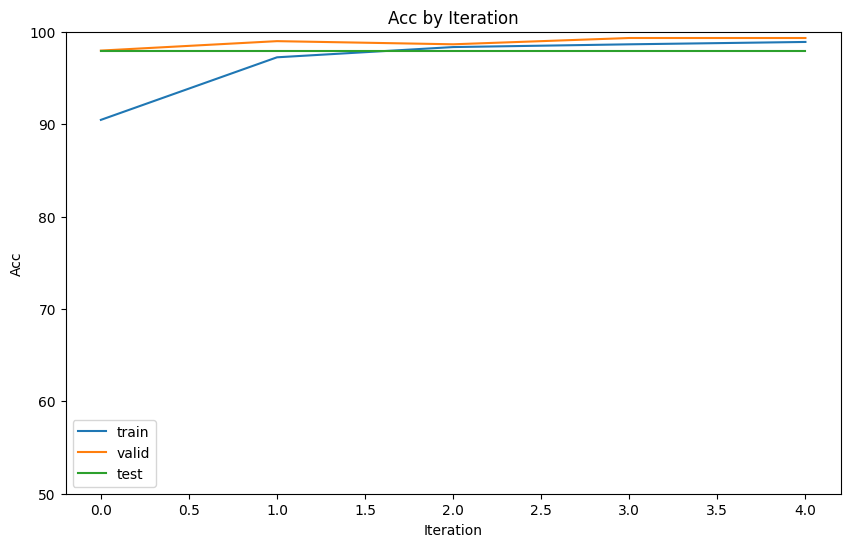

In [ ]:
plot_acc(train_acc_history,val_acc_history,test_acc)

# Save Model

In [ ]:
#save model

torch.save(model2.state_dict(), '/content/drive/MyDrive/Object_Classification_Assignment/Alexnet.pth')

# Model2(Modified AlexNet) predictions


Motorbikes


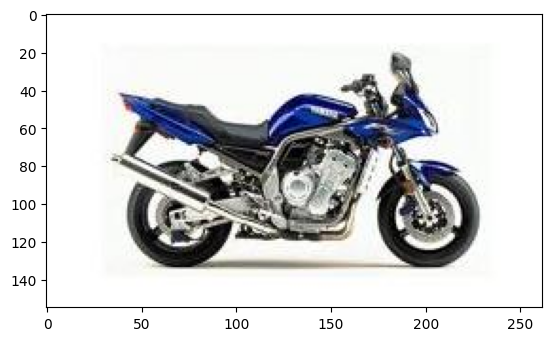

In [ ]:
 img_path = test_data['Filepath'][47]
 model_prediction(img_path,model2)

In [ ]:
img_path = test_data['Filepath'][120]
model_prediction(img_path,model2)

airplanes


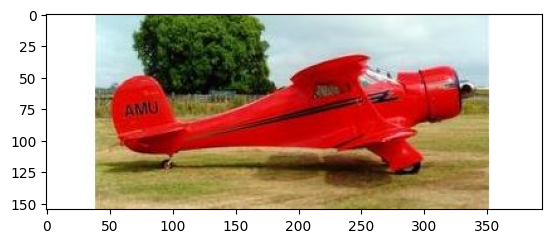

In [ ]:
img_path = test_data['Filepath'][10]
model_prediction(img_path,model2)